In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
fake_df=pd.read_csv("/content/Fake.csv.zip")

In [3]:
true_df=pd.read_csv("/content/True.csv.zip")

In [4]:
fake_df.sample(5)

,title,text,subject,date
3811,Trump Brings Us DANGEROUSLY Close To State-Ru...,"Trump has just made his campaign CEO, Steve Ba...",News,"November 14, 2016"
11010,“NUTTY” NANCY PELOSI Refers To President Trump...,"For the second time in a matter of weeks, prog...",politics,"Apr 30, 2017"
15333,HILLARY CLINTON HANDS OVER A BLANK SERVER TO T...,We should call her Slick Hillary after her hus...,politics,"Aug 13, 2015"
21223,HOLLYWOOD PORN DIRECTOR Makes Chappaquiddick M...,Is there ever a time the Left isn t portrayed ...,left-news,"Dec 15, 2015"
7666,Fox News’ Attack On Bernie Sanders Hilariousl...,"On February 25th, Fox News Business brought on...",News,"March 6, 2016"


In [5]:
print("Fake News Duplicates:", fake_df.duplicated().sum())
print("Real News Duplicates:", true_df.duplicated().sum())


Fake News Duplicates: 3
Real News Duplicates: 206


In [6]:
fake_df = fake_df.drop_duplicates()
true_df = true_df.drop_duplicates()

In [7]:
fake_df['label'] = 0
true_df['label'] = 1


In [8]:
fake_df = fake_df.drop(columns=['date', 'subject'])
true_df = true_df.drop(columns=['date', 'subject'])


In [9]:

data = pd.concat([fake_df, true_df], ignore_index=True)

In [10]:
data['content'] =  data['text']


In [11]:
data = data.drop(columns=['title', 'text'])


In [12]:
print(data.head())
print(data.columns)


   label                                            content
0      0  Donald Trump just couldn t wish all Americans ...
1      0  House Intelligence Committee Chairman Devin Nu...
2      0  On Friday, it was revealed that former Milwauk...
3      0  On Christmas day, Donald Trump announced that ...
4      0  Pope Francis used his annual Christmas Day mes...
Index(['label', 'content'], dtype='object')


In [13]:
# Group duplicates by content and view groups with more than 1 occurrence
duplicate_groups = data[data.duplicated(subset='content', keep=False)]
duplicate_sets = duplicate_groups.groupby('content').filter(lambda x: len(x) > 1)
duplicate_sets.sort_values(by='content').head(10)  # Show sample


,label,content
19555,0,
11491,0,
11489,0,
11487,0,
11476,0,
11473,0,
11471,0,
11492,0,
11470,0,
11462,0,


In [14]:
# Group duplicates by content and view groups with more than 1 occurrence
duplicate_groups = data[data.duplicated(subset='content', keep=False)]
duplicate_sets = duplicate_groups.groupby('content').filter(lambda x: len(x) > 1)
duplicate_sets.sort_values(by='content').head(10)  # Show sample
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and WordNet data (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
data['clean_content'] = data['content'].apply(preprocess_text)


In [16]:
final_data = data[['clean_content']]


In [17]:
final_data.sample()

,clean_content
42699,puerto ordaz venezuela reuters venezuelan driv...


In [18]:
y = data['label']

In [19]:
y.head(5)

,label
0,0
1,0
2,0
3,0
4,0


In [20]:
pip install gensim


In [25]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = final_data[['clean_content']]  # independent variable
y = data['label']            # target variable (make sure it exists)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare the data (X_train, y_train, etc. are already available)
X_train_texts = X_train['clean_content'].tolist()
X_test_texts = X_test['clean_content'].tolist()

# Tokenize into words for Word2Vec
X_train_tokens = [text.split() for text in X_train_texts]
X_test_tokens = [text.split() for text in X_test_texts]

# Step 1: Train Word2Vec
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_texts)
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Step 2: Convert text to padded sequences
maxlen = 100  # you can change this based on your average text length
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Convert y to numpy
y_train_array = y_train.values
y_test_array = y_test.values

# Step 3: Build RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train_pad, y_train_array, validation_data=(X_test_pad, y_test_array), epochs=5, batch_size=64)


Epoch 1/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8520 - loss: 0.3323 - val_accuracy: 0.9284 - val_loss: 0.1967
Epoch 2/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9185 - loss: 0.2098 - val_accuracy: 0.9168 - val_loss: 0.2027
Epoch 3/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9257 - loss: 0.1940 - val_accuracy: 0.9057 - val_loss: 0.2473
Epoch 4/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9239 - loss: 0.2131 - val_accuracy: 0.9391 - val_loss: 0.1752
Epoch 5/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9326 - loss: 0.1868 - val_accuracy: 0.9126 - val_loss: 0.2146


**LSTMt**

In [28]:
final_data.sample()

,clean_content
35851,moscow reuters russian defence minister sergei...


In [29]:
y.sample()

,label
22456,0


In [30]:
data.head()

,label,content,clean_content
0,0,Donald Trump just couldn t wish all Americans ...,donald trump just couldn t wish all americans ...
1,0,House Intelligence Committee Chairman Devin Nu...,house intelligence committee chairman devin nu...
2,0,"On Friday, it was revealed that former Milwauk...",on friday it was revealed that former milwauke...
3,0,"On Christmas day, Donald Trump announced that ...",on christmas day donald trump announced that h...
4,0,Pope Francis used his annual Christmas Day mes...,pope francis used his annual christmas day mes...


In [34]:
import pandas as pd



X_text = data['content']   # or maybe 'title' or 'content' — depends on your dataset
y = data['label']       # the target variable: 0 (fake), 1 (real)


In [35]:
# Assuming you've already tokenized your text into sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)  # X_text is your original list of text data

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(X_text)

# Choose max_length
max_length = max(len(seq) for seq in sequences)
print(f"Max length of sequences: {max_length}")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential()

# 1. Embedding layer (use Word2Vec embedding matrix here)
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))  # keep embeddings fixed

# 2. LSTM layer
model.add(LSTM(128, return_sequences=False))  # you can set return_sequences=True for stacked LSTMs
model.add(Dropout(0.3))

# 3. Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Summary
model.summary()


Max length of sequences: 8375


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    20,292,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,292,000 (77.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,292,000 (77.41 MB)

In [36]:
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_test_pad, y_test),
                    epochs=5,
                    batch_size=64)


Epoch 1/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9247 - loss: 0.1813 - val_accuracy: 0.9748 - val_loss: 0.0706
Epoch 2/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9801 - loss: 0.0579 - val_accuracy: 0.9848 - val_loss: 0.0474
Epoch 3/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9877 - loss: 0.0365 - val_accuracy: 0.9856 - val_loss: 0.0451
Epoch 4/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9917 - loss: 0.0252 - val_accuracy: 0.9896 - val_loss: 0.0359
Epoch 5/5
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9960 - loss: 0.0139 - val_accuracy: 0.9888 - val_loss: 0.0394


In [37]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9887 - loss: 0.0422
Test Accuracy: 0.9888


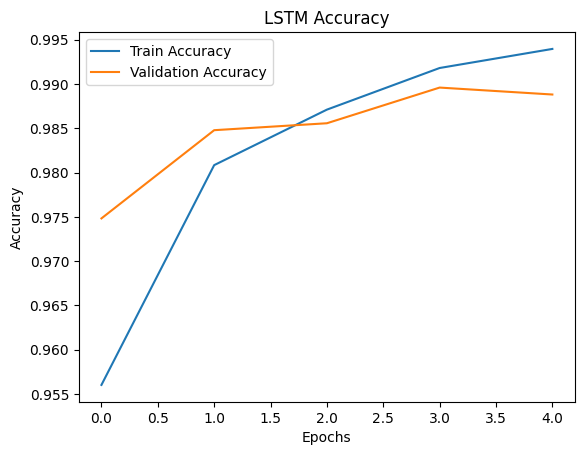

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()


In [40]:
print(embedding_matrix[:5])  # Should show non-zero values if Word2Vec was used


[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.     

In [41]:
non_zero_rows = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
total_words = embedding_matrix.shape[0]
print(f"Words with Word2Vec embeddings: {non_zero_rows} / {total_words}")


Words with Word2Vec embeddings: 202919 / 202920
